# Start

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터 로드
log_data = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/2022빅콘테스트_데이터분석리그_데이터분석분야_퓨처스부문_데이터셋_220908.zip (Unzipped Files)/log_data.csv') 
log_data['timestamp'] = pd.to_datetime(log_data['timestamp'])
log_data = log_data.drop(['mp_os', 'mp_app_version'], axis=1)


# train dataset 전처리

5월까지의 데이터만 train dataset으로 사용하고 있으므로 log_data에서도 같은 처리

In [4]:
train = log_data[log_data['timestamp']<'2022-06-01']

## is_applied 이벤트 추가

전처리 후 결합된 user_spec + loan_result 테이블에서 is_applied==1인 행을 가져와 알맞은 timestamp 시점에 끼워넣음. 
\
해당 행은 새로운 이벤트인 ClickApply로 만들어 행동 로그 취급.

In [5]:
# import pandas as pd
data = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/전처리한 데이터 셋/모델링용 데이터/merged_df.csv')
data['loanapply_insert_time'] = pd.to_datetime(data['loanapply_insert_time'])
data['user_id']=data['user_id'].astype('int')

In [6]:
# train에 해당하는 5월까지의 데이터 중 is_applied=1인 행만 가져옴
click_apply = data.loc[(data['is_applied']==1)&(data['loanapply_insert_time']<'2022-06-01'), 
                             ['user_id','loanapply_insert_time','is_applied']] 
click_apply.sort_values(by=['user_id','loanapply_insert_time'], inplace=True)

In [7]:
del data

In [8]:
# train 데이터에 concat할 수 있도록 컬럼 정리
click_apply = click_apply.rename(columns={'loanapply_insert_time': 'timestamp'})
click_apply['date_cd'] = click_apply['timestamp'].dt.strftime('%Y-%m-%d')
click_apply['date_cd'].astype('object')
click_apply['event'] = 'ClickApply'

click_apply = click_apply[list(train.columns)+['is_applied']]

In [10]:
# click_apply와 동일하게 train에도 is_applied 열을 만들어두기
train['is_applied'] = 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# train 데이터에 is_applied=1 행을 추가하고 시간대로 정렬
train = pd.concat([train, click_apply])
train.sort_values(by=['timestamp'], inplace=True)
train

,user_id,event,timestamp,date_cd,is_applied
4836383,720911,OpenApp,2022-03-01 00:00:00,2022-03-01,0.0
475653,125129,UseLoanManage,2022-03-01 00:00:00,2022-03-01,0.0
3640942,385811,Login,2022-03-01 00:00:00,2022-03-01,0.0
2845644,706858,GetCreditInfo,2022-03-01 00:00:03,2022-03-01,0.0
2809,512341,EndLoanApply,2022-03-01 00:00:03,2022-03-01,0.0
...,...,...,...,...,...
4889343,115372,EndLoanApply,2022-05-31 23:59:54,2022-05-31,0.0
11294886,681831,GetCreditInfo,2022-05-31 23:59:54,2022-05-31,0.0
6979109,845575,ViewLoanApplyIntro,2022-05-31 23:59:57,2022-05-31,0.0
6979107,845575,StartLoanApply,2022-05-31 23:59:57,2022-05-31,0.0


In [13]:
del click_apply

## 이전 행동

유저가 각 행동 로그를 남기기 직전의 행동 로그. 접속 날짜가 다를 경우, 다른 접속으로 분류.

### -1번째 refer_event
\
해당 행동을 하기 전 첫번째 행동 로그

In [14]:
train.sort_values(by=['user_id','date_cd'], inplace=True)

In [15]:
train['refer_event_1'] = ['start'] + list(train['event'])[:-1] # 해당일에 유저가 처음으로 한 행동 직전의 로그는 'start'로 반영.
start = train.drop_duplicates(['user_id', 'date_cd'])
train.loc[start.index, 'refer_event_1'] = 'start'

### -2번째 refer_event
\
해당 행동을 하기 전 두번째 행동 로그

In [17]:
train['refer_event_2'] = ['Null'] + list(train['refer_event_1'])[:-1] # 해당일에 유저에게 더이상 반영할 수 있는 이전 로그가 없다면 Null로 채움.
start = train.drop_duplicates(['user_id', 'date_cd'])
train.loc[start.index, 'refer_event_2'] = 'Null' 

### -3번째 refer_event

In [18]:
train['refer_event_3'] = ['Null'] + list(train['refer_event_2'])[:-1]
start = train.drop_duplicates(['user_id', 'date_cd'])
train.loc[start.index, 'refer_event_3'] = 'Null'

### -4번째 refer_event

In [19]:
train['refer_event_4'] = ['Null'] + list(train['refer_event_3'])[:-1]
start = train.drop_duplicates(['user_id', 'date_cd'])
train.loc[start.index, 'refer_event_4'] = 'Null'

### -5번째 refer_event

In [20]:
train['refer_event_5'] = ['Null'] + list(train['refer_event_4'])[:-1]
start = train.drop_duplicates(['user_id', 'date_cd'])
train.loc[start.index, 'refer_event_5'] = 'Null'

## 앱에 머무른 시간

유저가 접속마다 얼마나 앱에서 얼마나 머물렀는지 초를 계산. 일마다 마지막 행동 로그의 timestamp에서 첫번째 timestamp를 뺌.

In [22]:
# user_id와 date_cd로 이중인덱스를 설정하여 접속을 분리함.
train = train.set_index(['user_id', 'date_cd']).sort_index()

In [ ]:
# 실행하지 않는 셀
# train['stay_time'] = 0

# from tqdm import tqdm

# for i, v in tqdm(list(set(train.index))): #id_list: pd.Series(user_id).unique()
#     same_id_date = train.loc[(i,v)]
#     first_timestamp = pd.to_datetime(same_id_date.iloc[0]['timestamp']) # 첫번째 timestamp 찾기
#     last_timestamp = pd.to_datetime(same_id_date.iloc[len(same_id_date)-1]['timestamp']) # 마지막 timestamp 찾기
#     t = (last_timestamp - first_timestamp).seconds
#     if t > 0:
#         train.loc[(i,v)].iloc[len(same_id_date)-1, -1] = t

  0%|          | 0/377433 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
 56%|█████▌    | 210853/377433 [2:08:43<1:32:37, 29.98it/s]

계산이 너무 오래 걸리므로 원본 데이터를 5등분하여 계산. 각 파일은 data4_1.csv~data4_5.csv로 저장해놓고 다시 불러서 데이터에 덧붙임.

In [23]:
train = train.reset_index()

In [24]:
df1 = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/train_staytime_1.csv')
sec = df1['stay_time']
train['stay_time'] = 0
train.iloc[:2693584, -1] = sec # data_1: :2693584
del sec, df1

In [25]:
df1 = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/train_staytime_2.csv')
sec = df1['stay_time'][97:] #2693584-2693487=97
train.iloc[2693584:5386964, -1] = sec # data_2: 2693487:5386964
del sec, df1

In [26]:
df1 = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/train_staytime_3.csv')
sec = df1['stay_time']
train.iloc[5386964:8080455, -1] = sec # data_3: 5386964:8080455
del sec, df1

In [27]:
df1 = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/train_staytime_4.csv')
sec = df1['stay_time']
train.iloc[8080455:10773932, -1] = sec # data_4: 8080455:10773932
del sec, df1

In [28]:
df1 = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/train_staytime_5.csv')
sec = df1['stay_time']
train.iloc[10773932:, -1] = sec # data_5: 10773932:
del sec, df1

## 대출 신청이 주로 일어나는 요일 및 시간

In [30]:
train['weekday'] = train['timestamp'].dt.weekday
train['hour'] = train['timestamp'].dt.hour

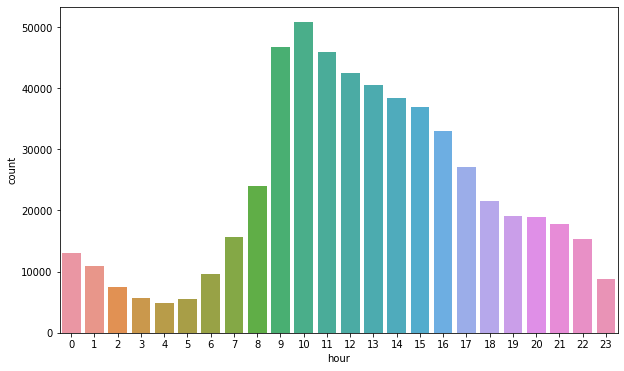

In [ ]:
df = train[train['is_applied']==1.0]

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='hour')

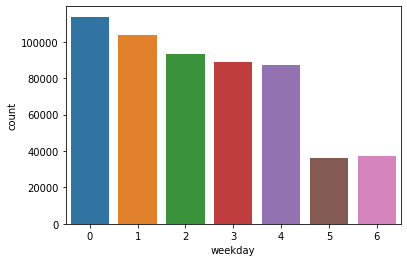

In [ ]:
sns.countplot(data=df, x='weekday')

유저가 대출을 많이 신청하는 시간대가 평일 & 9시~17시임을 확인. 이 시간대에 해당하는 행을 표시.

In [31]:
train['week_pop'] = [0] * len(train)
train.loc[(train['weekday'] <=4)&(train['hour'].isin([i for i in range(9, 17+1)])), 'week_pop'] = 1
train.drop(['weekday','hour'], axis=1, inplace=True)

## 기능 이용 시간

각 이벤트마다 소요되는 시간. 다음 행동 로그가 일어난 timestamp에서 현재 행동 로그의 timestamp를 뺌.


In [32]:
train = train.sort_values(by=['user_id','date_cd','timestamp'])

In [33]:
after_time = list(train['timestamp'])[1:] + ['2022-05-24 22:33:32']
after_time = pd.DataFrame(after_time, columns=['after_time'])
after_time['after_time'] = pd.to_datetime(after_time['after_time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  


In [35]:
spend_time = after_time['after_time'] - train['timestamp']
train['spend_time'] = spend_time.dt.seconds

In [37]:
idx = list(train[train['refer_event_1']=='start'].index)
idx = [i-1 for i in idx]
train.iloc[idx[1:], -1] = 0

In [39]:
# 마지막 행동 로그이거나 유일한 행동 로그라서 소요 시간을 알 수 없는 경우, spend_time의 중앙값 6을 넣음
train.iloc[idx[1:], -1] = train['spend_time'].median() # 6.0

## 하루 내 2번 이상 접속한 경우

refer_event, stay_time, spend_time 모두 유저가 같은 날짜에 1번만 접속했음을 가정하고 계산 된 변수. 그러나 유저가 같은 날에도 시간 텀을 두고 2번 이상 접속했을 경우가 있음.
\
만약 spend_time이 비정상적으로 크다면(1시간 이상), 같은 날의 다른 접속인 것으로 판단하고 refer_event, stay_time, spend_time 다시 계산.

In [41]:
end = train[train['spend_time']>=3600] # 하루 내 접속을 종료하는 시점
train.loc[[i+1 for i in end.index], 'refer_event_1']='start' # 다시 접속할 경우, refer_event_1를 start로 변경
train.loc[end.index, 'spend_time'] = 6 # 접속을 종료하는 시점의 행동 로그의 spend_time은 6으로 변경
del end

In [43]:
start = train[train['refer_event_1']=='start'] # 하루 내 접속을 다시 시작하는 시점
start_idx = list(start.index) + [i-1 for i in start.index] # start 시점과 그 직전 시점(이전 접속의 마지막 행동)만 추출

In [44]:
twice_use = train.iloc[start_idx] # start 시점과 해당 접속에서 마지막 행동을 한 시점을 추출
twice_use = twice_use.sort_values(by = ['user_id','timestamp'])

In [49]:
from tqdm import tqdm

secs = []
for i in tqdm(range(len(twice_use))):
    if i%2==1: # 홀수일 때 건너뛰기
      continue
    else:
      # 마지막 행동에서 start의 timestamp를 빼서 해당 접속의 stay time을 계산
      sec = int((twice_use.iloc[i+1, 3] - twice_use.iloc[i, 3]).total_seconds()) 
      secs.append(sec)

100%|██████████| 5024150/5024150 [04:53<00:00, 17107.99it/s]


In [53]:
train.iloc[[i-1 for i in start.index][1:], -3] = secs[:-1] # refer_event_1='start'의 직전(이전 접속의 마지막 행동) 레코드마다 stay_time 넣음
train.iloc[[i-1 for i in start.index][0], -3] = secs[-1]

In [56]:
del start, start_idx, twice_use, secs

In [57]:
train.drop('is_applied', axis=1, inplace=True)

In [ ]:
train.to_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/train_log_data_1.csv', index=False, encoding="utf-8-sig")

# test dataset 전처리

6월부터는 test dataset으로 사용. train과 같은 전처리 적용.

In [ ]:
test = log_data[log_data['timestamp']>='2022-06-01']

## is_applied 이벤트 추가

6월 이후로는 is_applied 여부를 알 수 없으므로 이 전처리는 생략.

## 이전 행동

유저가 각 행동 로그를 남기기 직전의 행동 로그. 접속 날짜가 다를 경우, 다른 접속으로 분류.

### -1번째 refer_event
\
해당 행동을 하기 전 첫번째 행동 로그

In [ ]:
test.sort_values(by=['user_id','date_cd'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
test['refer_event_1'] = ['start'] + list(test['event'])[:-1] # 해당일에 유저가 처음으로 한 행동 직전의 로그는 'start'로 반영.
start = test.drop_duplicates(['user_id', 'date_cd'])
test.loc[start.index, 'refer_event_1'] = 'start'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### -2번째 refer_event
\
해당 행동을 하기 전 두번째 행동 로그

In [ ]:
test['refer_event_2'] = ['Null'] + list(test['refer_event_1'])[:-1] # 해당일에 유저에게 더이상 반영할 수 있는 이전 로그가 없다면 Null로 채움.
start = test.drop_duplicates(['user_id', 'date_cd'])
test.loc[start.index, 'refer_event_2'] = 'Null' 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### -3번째 refer_event

In [ ]:
test['refer_event_3'] = ['Null'] + list(test['refer_event_2'])[:-1]
start = test.drop_duplicates(['user_id', 'date_cd'])
test.loc[start.index, 'refer_event_3'] = 'Null'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### -4번째 refer_event

In [ ]:
test['refer_event_4'] = ['Null'] + list(test['refer_event_3'])[:-1]
start = test.drop_duplicates(['user_id', 'date_cd'])
test.loc[start.index, 'refer_event_4'] = 'Null'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### -5번째 refer_event

In [ ]:
test['refer_event_5'] = ['Null'] + list(test['refer_event_4'])[:-1]
start = test.drop_duplicates(['user_id', 'date_cd'])
test.loc[start.index, 'refer_event_5'] = 'Null'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 앱에 머무른 시간

유저가 접속마다 얼마나 앱에서 얼마나 머물렀는지 초를 계산. 일마다 마지막 행동 로그의 timestamp에서 첫번째 timestamp를 뺌.

In [ ]:
# user_id와 date_cd로 이중인덱스를 설정하여 접속을 분리함.
test = test.set_index(['user_id', 'date_cd']).sort_index()

In [ ]:
# 실행하지 않는 셀
# test['stay_time'] = 0

# from tqdm import tqdm

# for i, v in tqdm(list(set(test.index))): #id_list: pd.Series(user_id).unique()
#     same_id_date = test.loc[(i,v)]
#     first_timestamp = pd.to_datetime(same_id_date.iloc[0]['timestamp']) # 첫번째 timestamp 찾기
#     last_timestamp = pd.to_datetime(same_id_date.iloc[len(same_id_date)-1]['timestamp']) # 마지막 timestamp 찾기
#     t = (last_timestamp - first_timestamp).seconds
#     if t > 0:
#         test.loc[(i,v)].iloc[len(same_id_date)-1, -1] = t

  0%|          | 0/377433 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
 56%|█████▌    | 210853/377433 [2:08:43<1:32:37, 29.98it/s]

계산이 너무 오래 걸리므로 원본 데이터를 이등분하여 계산. 각 파일은 test_data_1.csv~test_data_2.csv로 저장해놓고 다시 불러서 데이터에 덧붙임.

In [ ]:
test = test.reset_index()

In [ ]:
df1 = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/test_staytime_1.csv')
sec = df1['stay_time']
test['stay_time'] = 0
test.iloc[:2468390, -1] = sec # test_data_1: :2468390
del sec, df1

In [ ]:
df1 = pd.read_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/test_staytime_2.csv')
sec = df1['stay_time']
test.iloc[2468390:, -1] = sec # test_data_2: 2468390:
del sec, df1

## 대출 신청이 주로 일어나는 요일 및 시간

In [ ]:
test['weekday'] = test['timestamp'].dt.weekday
test['hour'] = test['timestamp'].dt.hour

유저가 대출을 많이 신청하는 시간대가 평일 & 9시~17시임을 확인. 이 시간대에 해당하는 행을 표시.

In [ ]:
test['week_pop'] = [0] * len(test)
test.loc[(test['weekday'] <=4)&(test['hour'].isin([i for i in range(9, 17+1)])), 'week_pop'] = 1
test.drop(['weekday','hour'], axis=1, inplace=True)

## 기능 이용 시간

각 이벤트마다 소요되는 시간. 다음 행동 로그가 일어난 timestamp에서 현재 행동 로그의 timestamp를 뺌.


In [ ]:
test = test.sort_values(by=['user_id','date_cd','timestamp'])

In [ ]:
after_time = list(test['timestamp'])[1:] + ['2022-06-29 17:20:45']
after_time = pd.DataFrame(after_time, columns=['after_time'])
after_time['after_time'] = pd.to_datetime(after_time['after_time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  


In [ ]:
spend_time = after_time['after_time'] - test['timestamp']
test['spend_time'] = spend_time.dt.seconds

In [ ]:
idx = list(test[test['refer_event_1']=='start'].index)
idx = [i-1 for i in idx]
test.iloc[idx[1:], -1] = 0

In [ ]:
# 마지막 행동 로그이거나 유일한 행동 로그라서 소요 시간을 알 수 없는 경우, train에서 넣었던 spend_time의 중앙값 6을 넣음
test.iloc[idx[1:], -1] = 6.0

## 하루 내 2번 이상 접속한 경우

refer_event, stay_time, spend_time 모두 유저가 같은 날짜에 1번만 접속했음을 가정하고 계산 된 변수. 그러나 유저가 같은 날에도 시간 텀을 두고 2번 이상 접속했을 경우가 있음.
\
만약 spend_time이 비정상적으로 크다면(1시간 이상), 같은 날의 다른 접속인 것으로 판단하고 refer_event, stay_time, spend_time 다시 계산.

In [ ]:
end = test[test['spend_time']>=3600] # 하루 내 접속을 종료하는 시점
test.loc[[i+1 for i in end.index], 'refer_event_1']='start' # 다시 접속할 경우, refer_event_1를 start로 변경
test.loc[end.index, 'spend_time'] = 6 # 접속을 종료하는 시점의 행동 로그의 spend_time은 6으로 변경
del end

In [ ]:
start = test[test['refer_event_1']=='start'] # 하루 내 접속을 다시 시작하는 시점
start_idx = list(start.index) + [i-1 for i in start.index] # start 시점과 그 직전 시점(이전 접속의 마지막 행동)만 추출

In [ ]:
twice_use = test.iloc[start_idx] # start 시점과 해당 접속에서 마지막 행동을 한 시점을 추출
twice_use = twice_use.sort_values(by = ['user_id','timestamp'])

In [ ]:
from tqdm import tqdm

secs = []
for i in tqdm(range(len(twice_use))):
    if i%2==1: # 홀수일 때 건너뛰기
      continue
    else:
      # 마지막 행동에서 start의 timestamp를 빼서 해당 접속의 stay time을 계산
      sec = int((twice_use.iloc[i+1, 3] - twice_use.iloc[i, 3]).total_seconds()) 
      secs.append(sec)

100%|██████████| 3214304/3214304 [03:10<00:00, 16841.29it/s]


In [ ]:
test.iloc[[i-1 for i in start.index][1:], -3] = secs[:-1] # refer_event_1='start'의 직전(이전 접속의 마지막 행동) 레코드마다 stay_time 넣음
test.iloc[[i-1 for i in start.index][0], -3] = secs[-1]

In [ ]:
del start, start_idx, twice_use, secs

In [ ]:
test.to_csv('/content/drive/Shareddrives/빅콘테스트/데이터/군집화/test_log_data_1.csv', index=False, encoding="utf-8-sig")

# html 파일로 변환

In [62]:
!jupyter nbconvert --to html "/content/drive/Shareddrives/빅콘테스트/제출파일/코드내용 정리된 파일(Ipynb, Py)/log_data 전처리.ipynb"

[NbConvertApp] Converting notebook /content/drive/Shareddrives/빅콘테스트/제출파일/코드내용 정리된 파일(Ipynb, Py)/log_data 전처리.ipynb to html
[NbConvertApp] Writing 398635 bytes to /content/drive/Shareddrives/빅콘테스트/제출파일/코드내용 정리된 파일(Ipynb, Py)/log_data 전처리.html
